# Experiments

In [11]:
import numpy as np
import math
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import os
from data.load_data import load_monk, load_MLCup
from src.MetricFunctions import get_metric_instance
from src.MLP import MLP
from src.GridSearch import GridSearch, RandomGridsearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from src.EarlyStopping import EarlyStopping
from tqdm import tqdm
from warnings import filterwarnings
filterwarnings('ignore')


## Task 1: Classification

### Preparation: Loading Monk Datasets

In [12]:
path = os.getcwd()

labels = ['class','x1','x2','x3','x4','x5','x6']
tanh_labels = True
TR_sets = [[]] 
TS_sets = [[]] 


for i in range(1,4):
    TR = load_monk(path + f'/data/monks-{i}.train', labels)
    TS = load_monk(path + f'/data/monks-{i}.test', labels)
    if tanh_labels:
        for j in range(len(TS[1])):
            if int(TS[1][j]) == 0:
                TS[1][j] = -1

        for j in range(len(TR[1])):
            if int(TR[1][j]) == 0:
                TR[1][j] = -1
    TR_sets.append(TR)
    TS_sets.append(TS)

print(TS_sets[1][1].shape)

(432, 1)


### Experiment 1.1 - Random runs with tanh activation

Test set accuracies:
MONK's 1: 1.0
MONK's 2: 1.0
MONK's 3: 0.935
MONK's 3: 0.972


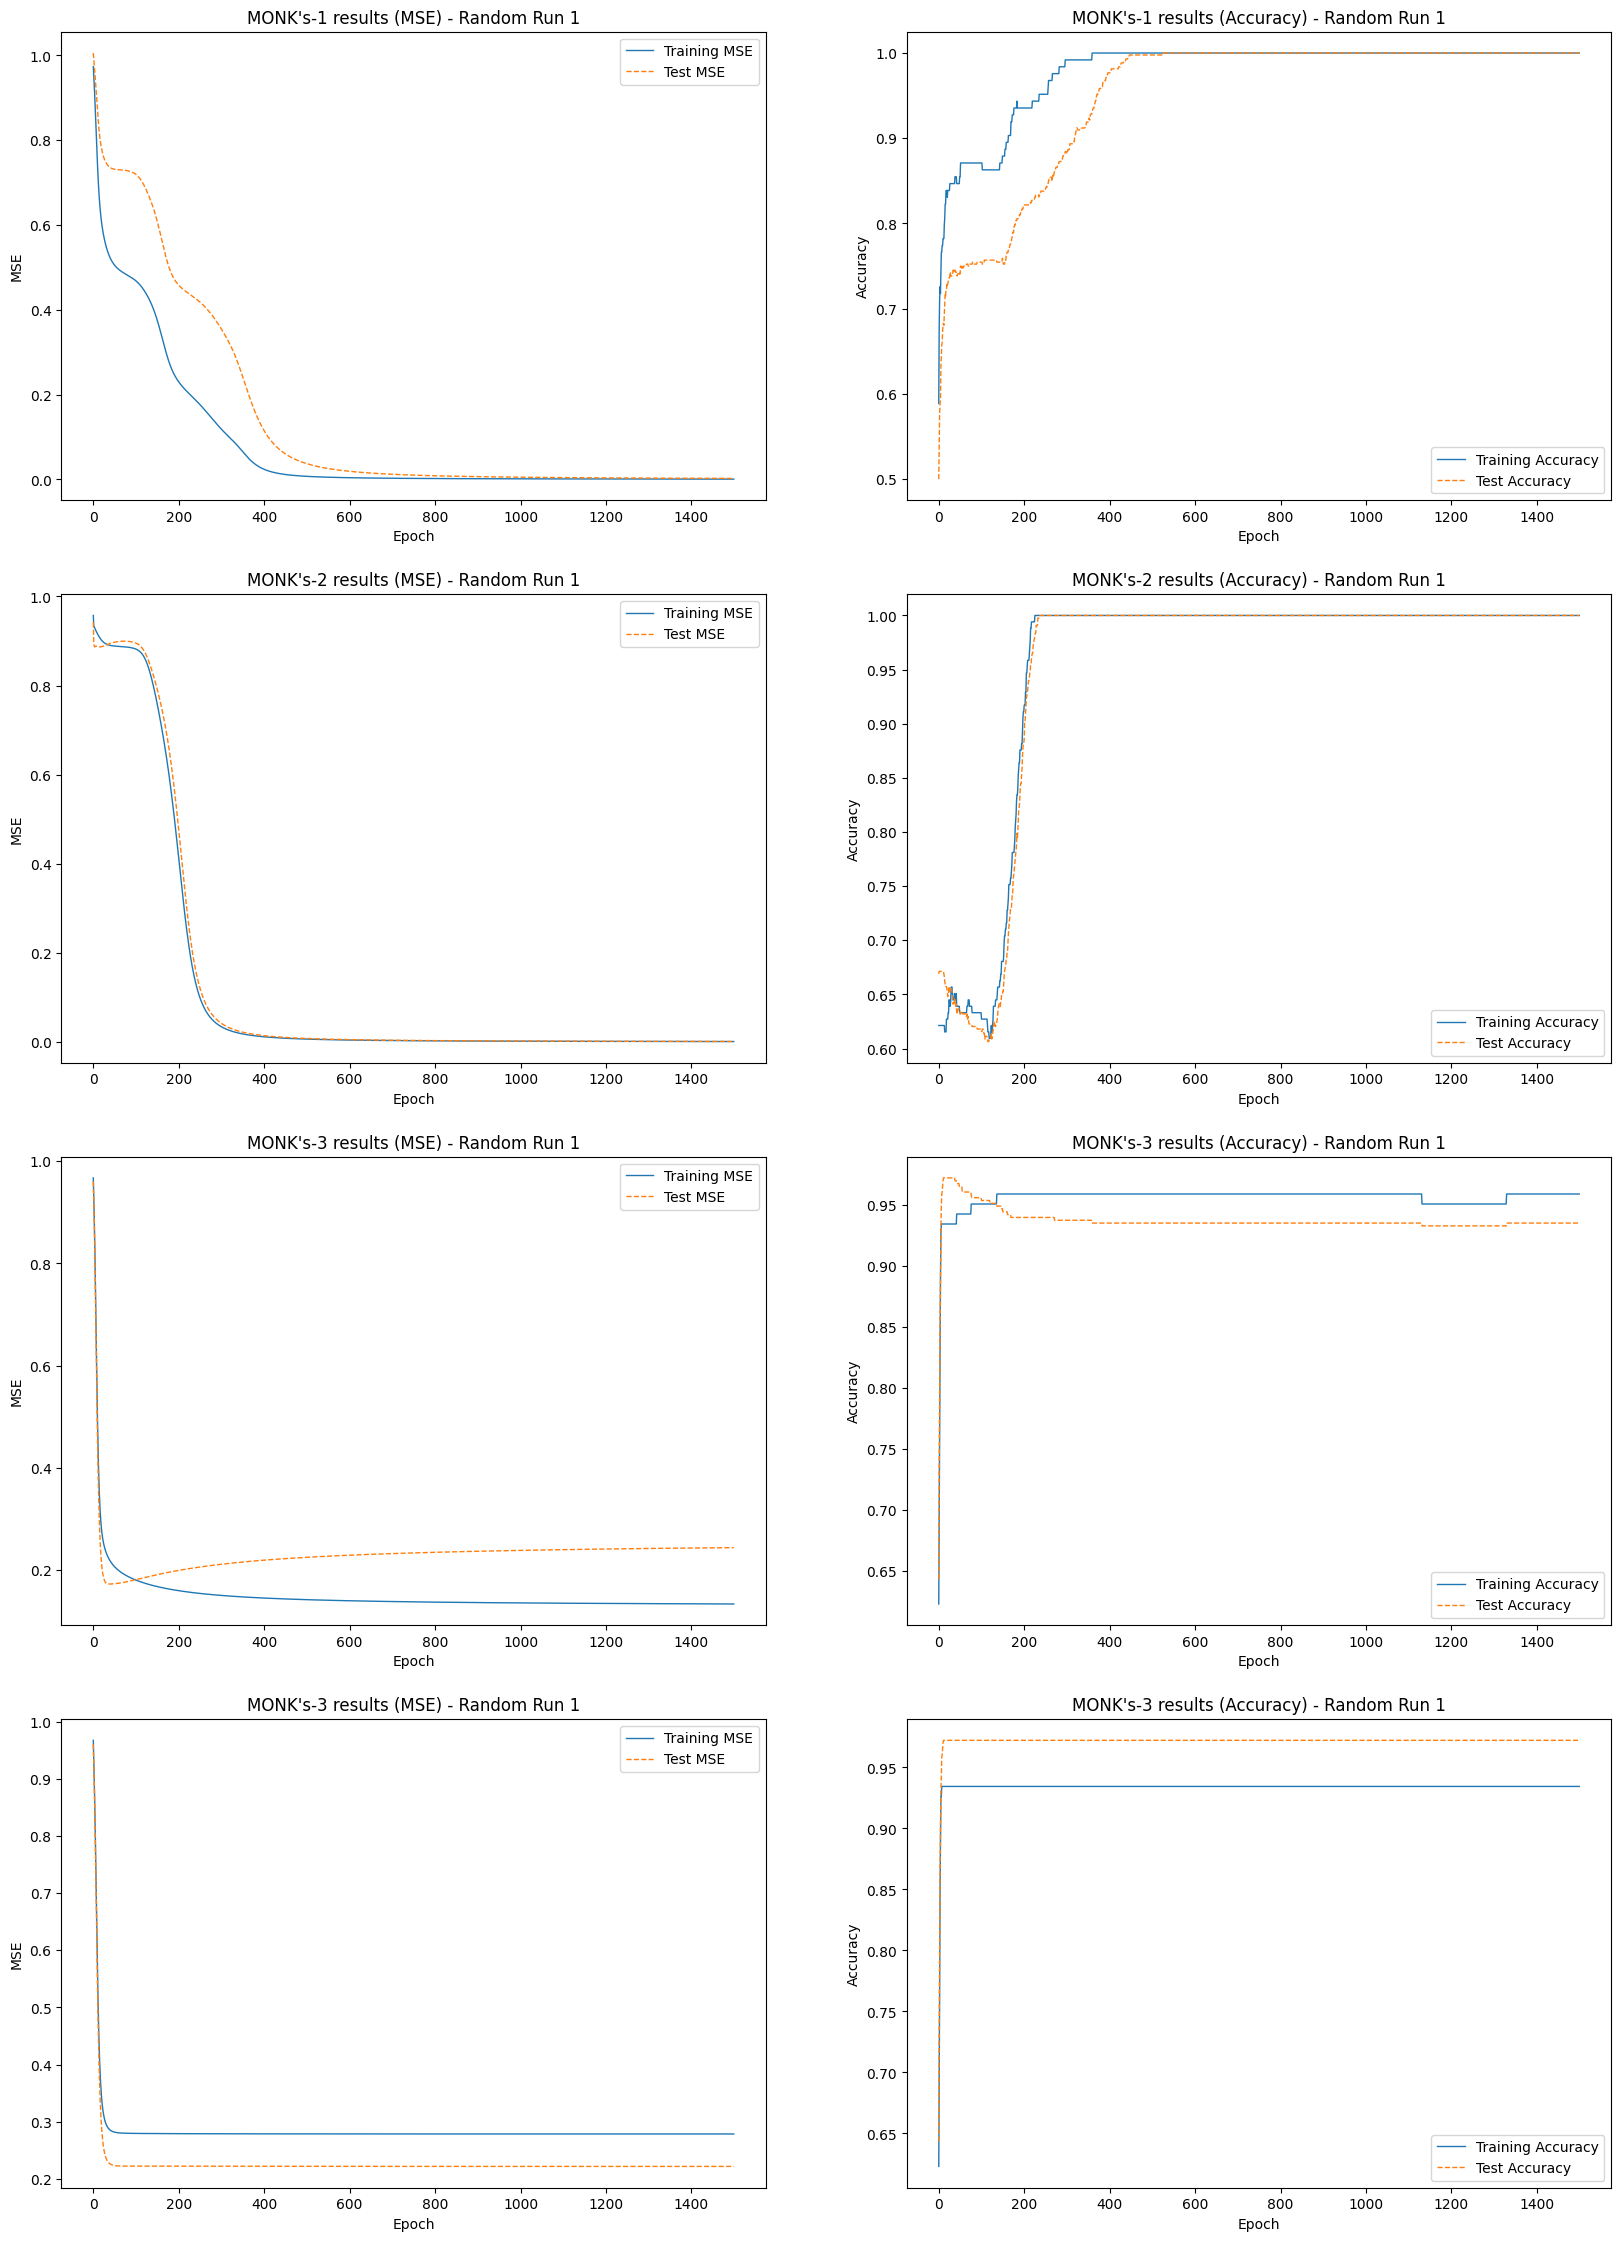

In [13]:
path_results = os.getcwd() + '/results/MonkResults.txt'
path_plots = os.getcwd() + '/results/MonkPlots.png'
curves = []
params = {
    "n_epochs" : 1500, 
    "error" : "mse", 
    "verbose" : False,
    "step" : 0.15, 
    "momentum" : 0.3,
    "weights_initialization" : 'xavier',
    "early_stopping" : False,
    "eval_metric" : 'mse'
    }

super_verbose = True
verbose = True
number_runs = 3
# Statistics of all random runs
MSE_TR = np.zeros((number_runs, 4))
MSE_TS = np.zeros((number_runs, 4))
ACC_TR = np.zeros((number_runs, 4))
ACC_TS = np.zeros((number_runs, 4))

def name(i):
    if i in (0,1,2):
        return i + 1
    else:
        return i

def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

for k in range(number_runs):

    curves = []
    
    for i in range(0,4):

        input_size = TR_sets[name(i)][0][0].shape[0]
        n_samples = TR_sets[name(i)][0].shape[0]
        params["batch_size"] = n_samples
        
        mlp = MLP([3], input_size = input_size, output_size = 1, task = "classification", activation_function = 'tanh', random_seed = k)

        # Curves with MSE/Accuracy
        if i < 3:
            # All without regularization
            params["regularization"] = 'no'
            # params["regularization"] = 'l2'
            # params["alpha_l2"] = 0.0075
            mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
        else:
            # Monk 3 with regularization
            params["regularization"] = 'l2'
            params["alpha_l2"] = 0.05
            mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
        
        curves.append([[mlp.learning_curve, mlp.learning_accuracy_curve], [mlp.validation_curve, mlp.test_accuracy_curve]])
        
        MSE_TR[k, i] = mlp.learning_curve[-1]
        MSE_TS[k, i] = mlp.validation_curve[-1]
        ACC_TR[k, i] = mlp.learning_accuracy_curve[-1]
        ACC_TS[k, i] = mlp.test_accuracy_curve[-1]


    if k == 0:
        # Plot the learning curves
        figure, axis = plt.subplots(4, 2, figsize = (20, 28))
        
        for j in range(0,4):

            # Plot MSE training and validation curves
            axis[j, 0].plot(range(0, len(curves[j][0][0]), 1), curves[j][0][0],\
                linewidth = 1, label = 'Training MSE')
            axis[j, 0].plot(range(0, len(curves[j][1][0]), 1), curves[j][1][0],\
                linewidth = 1, label = 'Test MSE', linestyle = '--')
            axis[j, 0].set_title(f"MONK's-{name(j)} results (MSE) - Random Run {k + 1}")
            axis[j, 0].set_xlabel('Epoch') 
            axis[j, 0].set_ylabel('MSE')  
            axis[j, 0].legend()


            # Plot Accuracy training and validation curves
            axis[j, 1].plot(range(0, len(curves[j][0][1]), 1), curves[j][0][1],\
                linewidth = 1, label = 'Training Accuracy')
            axis[j, 1].plot(range(0, len(curves[j][1][1]), 1), curves[j][1][1],\
                linewidth = 1, label = 'Test Accuracy', linestyle = '--')
            axis[j, 1].set_title(f"MONK's-{name(j)} results (Accuracy) - Random Run {k + 1}")
            axis[j, 1].set_xlabel('Epoch') 
            axis[j, 1].set_ylabel('Accuracy')  
            axis[j, 1].legend()
        
        plt.savefig(path_plots)
    

# Mean and standard deviation over the random runs
MSE_STAT_TR = [np.mean(MSE_TR, axis = 0), np.std(MSE_TR, axis = 0)]
MSE_STAT_TS = [np.mean(MSE_TS, axis = 0), np.std(MSE_TS, axis = 0)]
ACC_STAT_TR = [np.mean(ACC_TR, axis = 0), np.std(ACC_TR, axis = 0)]
ACC_STAT_TS = [np.mean(ACC_TS, axis = 0), np.std(ACC_TS, axis = 0)]

ACC_STATS = [ACC_STAT_TS[0][0], ACC_STAT_TS[0][1], ACC_STAT_TS[0][2], ACC_STAT_TS[0][3]]
CLEAN_ACC_STATS = [f"{truncate(STAT, 3)}" for STAT in ACC_STATS]

print(f"Test set accuracies:")
for h in range(4):
    print(f"MONK's {name(h)}" + ": " + CLEAN_ACC_STATS[h])

with open(path_results, 'w') as result_file:
    
    for m in range(4):

        if verbose == True:
            if m < 3:
                result_file.write(f"Results on MONK's {m + 1} over all random runs: \n")
            else: 
                result_file.write(f"Results on MONK's {m} with regularization over all random runs: \n")
        
            result_file.write("MSE on TR: " + str(MSE_STAT_TR[0][m]) + " +/- " + str(MSE_STAT_TR[1][m]) + '\n')
            result_file.write("MSE on TS: " + str(MSE_STAT_TS[0][m]) + " +/- " + str(MSE_STAT_TS[1][m]) + '\n')
            result_file.write("ACC on TR: " + str(ACC_STAT_TR[0][m]) + " +/- " + str(ACC_STAT_TR[1][m]) + '\n')
            result_file.write("ACC on TS: " + str(ACC_STAT_TS[0][m]) + " +/- " + str(ACC_STAT_TS[1][m]) + '\n')
            result_file.write('\n')  

## Task 2: Regression

Preparation: Loading MLCup Dataset

In [3]:
path = os.getcwd()
file_train = '/data/ML-CUP22-TR.csv'
file_test = '/data/ML-CUP22-TS.csv'

labels_train = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','y1','y2']
labels_test = ['x1','x2','x3','x4','x5','x6','x7','x8','x9']

X, y = load_MLCup(path + file_train, labels_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

X_blind_test = load_MLCup(path + file_test, labels_test)

### Experiment 2.1 - Gridsearch with Relu activation, topology [40, 20]

In [5]:
mlp = MLP([40, 20], 9, 2, task = "regression", activation_function = "relu")

params_grid = {
    "step": [0.008, 0.005, 0.003, 0.001],
    "momentum": [0.5 , 0.7, 0.8],
    'alpha_l2' : [0.005, 0.001, 0.0005, 0],
    'alpha_l1' : [0.005, 0.001, 0.0005, 0],            
    'Nesterov' : [True, False],             
    'rprop' : [False],
    'adaptive_gradient' : [False],
    "batch_size" : [-1, 500],                           
    'weights_initialization' : ['he'],      
    'regularization' : ['elastic'],
    'n_epochs' : [2500],
    'tolerance' : [1e-5],
    'patience': [20]                 
}

grid_40_20_relu = GridSearch(mlp)
grid_40_20_relu.fit(X_train, y_train, params_grid, n_folds = 5, parallel = True, verbose = False)

Grid search of 768 combinations.
Parallelisation activated


Parameters of best model, evaluated on mean validation error: {'step': 0.003, 'momentum': 0.8, 'alpha_l2': 0.005, 'alpha_l1': 0, 'Nesterov': True, 'rprop': False, 'adaptive_gradient': False, 'batch_size': 500, 'weights_initialization': 'he', 'regularization': 'elastic', 'n_epochs': 2500, 'tolerance': 1e-05, 'patience': 20}
Validation error on 5 folds for best model: [1.4617743543427575, 1.6247155458216973, 1.5242869506638699, 1.4431408280287377, 1.4949720837162246]
Mean validation error: 1.5097779525146575


###  Experiment 2.2 - Gridsearch with Relu activation, topology [60, 10]

In [6]:
mlp = MLP([60, 10], 9, 2, task = "regression", activation_function = "relu")

params_grid = {
    "step": [0.008, 0.005, 0.003, 0.001],
    "momentum": [0.5 , 0.7, 0.8],
    'alpha_l2' : [0.005, 0.001, 0.0005, 0],
    'alpha_l1' : [0.005, 0.001, 0.0005, 0],            
    'Nesterov' : [True, False],             
    'rprop' : [False],
    'adaptive_gradient' : [False],
    "batch_size" : [-1, 500],                           
    'weights_initialization' : ['he'],      
    'regularization' : ['elastic'],
    'n_epochs' : [2500],
    'tolerance' : [1e-5],
    'patience': [20]                
}


grid_60_10_relu = GridSearch(mlp)
grid_60_10_relu.fit(X_train, y_train, params_grid, n_folds = 5, parallel = True, verbose = False)

Grid search of 768 combinations.
Parallelisation activated


Parameters of best model, evaluated on mean validation error: {'step': 0.005, 'momentum': 0.8, 'alpha_l2': 0.005, 'alpha_l1': 0.001, 'Nesterov': False, 'rprop': False, 'adaptive_gradient': False, 'batch_size': 500, 'weights_initialization': 'he', 'regularization': 'elastic', 'n_epochs': 2500, 'tolerance': 1e-05, 'patience': 20}
Validation error on 5 folds for best model: [1.4785127023810611, 1.590522450846738, 1.521299543590954, 1.4534632482977732, 1.4975915057433058]
Mean validation error: 1.5082778901719662


###  Experiment 2.3 - Gridsearch with Tanh activation, topology [40, 20]

In [7]:
mlp = MLP([40, 20], 9, 2, task = "regression", activation_function = "tanh")

params_grid = {
    "step": [0.05, 0.03, 0.015, 0.0075],
    "momentum": [0.5, 0.7, 0.8],
    'alpha_l2' : [0.005, 0.001, 0.0005, 0],
    'alpha_l1' : [0.005, 0.001, 0.0005, 0],
    'Nesterov' : [True, False],             
    'rprop' : [False],
    'adaptive_gradient' : [False],
    "batch_size" : [-1, 500],                        
    'weights_initialization' : ['xavier'],      
    'regularization' : ['elastic'],
    'n_epochs' : [2500],
    'tolerance' : [1e-5],
    'patience': [20]                 
}

grid_40_20_tanh = GridSearch(mlp)
grid_40_20_tanh.fit(X_train, y_train, params_grid, n_folds = 5, parallel = True, verbose = False)


Grid search of 768 combinations.
Parallelisation activated


Parameters of best model, evaluated on mean validation error: {'step': 0.03, 'momentum': 0.7, 'alpha_l2': 0.0005, 'alpha_l1': 0.0005, 'Nesterov': True, 'rprop': False, 'adaptive_gradient': False, 'batch_size': -1, 'weights_initialization': 'xavier', 'regularization': 'elastic', 'n_epochs': 2500, 'tolerance': 1e-05, 'patience': 20}
Validation error on 5 folds for best model: [1.4163064971811545, 1.519544097261469, 1.4345144245812282, 1.4298850012871511, 1.437763879540304]
Mean validation error: 1.4476027799702613


###  Experiment 2.4 - Gridsearch with Tanh activation, topology [60, 10]

In [8]:
mlp = MLP([60, 10], 9, 2, task = "regression", activation_function = "tanh")

params_grid = {
    "step": [0.05, 0.03, 0.015, 0.0075],
    "momentum": [0.5, 0.7, 0.8],
    'alpha_l2' : [0.005, 0.001, 0.0005, 0],
    'alpha_l1' : [0.005, 0.001, 0.0005, 0],
    'Nesterov' : [True, False],             
    'rprop' : [False],
    'adaptive_gradient' : [False],
    "batch_size" : [-1, 500],                        
    'weights_initialization' : ['xavier'],      
    'regularization' : ['elastic'],
    'n_epochs' : [2500],
    'tolerance' : [1e-5],
    'patience': [20]             
}

grid_60_10_tanh = GridSearch(mlp)
grid_60_10_tanh.fit(X_train, y_train, params_grid, n_folds = 5, parallel = True, verbose = False)

Grid search of 768 combinations.
Parallelisation activated


Parameters of best model, evaluated on mean validation error: {'step': 0.015, 'momentum': 0.8, 'alpha_l2': 0, 'alpha_l1': 0.001, 'Nesterov': False, 'rprop': False, 'adaptive_gradient': False, 'batch_size': 500, 'weights_initialization': 'xavier', 'regularization': 'elastic', 'n_epochs': 2500, 'tolerance': 1e-05, 'patience': 20}
Validation error on 5 folds for best model: [1.452783478816241, 1.5147352741207372, 1.4649911145096919, 1.367015219629926, 1.4464978042643841]
Mean validation error: 1.4492045782681962


## Model Assessment

In [43]:
best_models = [grid_40_20_relu, grid_60_10_relu, grid_40_20_tanh, grid_60_10_tanh]
best_scores = [grid_40_20_relu.best_score, grid_60_10_relu.best_score, grid_40_20_tanh.best_score, grid_60_10_tanh.best_score]

best_model = best_models[best_scores.index(min(best_scores))]
params = best_model.best_parameters
print(f"Best model : {best_model.model.activation_function} with {best_model.model.hidden_layer_units} hidden layers")
print(f"Best parameters : {params}")
print(f"Best mean validation error : {best_model.best_score}")

Best model : tanh with [40, 20] hidden layers
Best parameters : {'step': 0.03, 'momentum': 0.7, 'alpha_l2': 0.0005, 'alpha_l1': 0.0005, 'Nesterov': True, 'rprop': False, 'adaptive_gradient': False, 'batch_size': -1, 'weights_initialization': 'xavier', 'regularization': 'elastic', 'n_epochs': 2500, 'tolerance': 1e-05, 'patience': 20}
Best mean validation error : 1.4476027799702613


Evaluation of TR/VL/TS errors of best model

In [10]:
# Get the best model
model = best_model.best_model
model.fit(X_train, y_train, **params)
y_pred = model.predict(X_test)

# Print the resulting errors
print(f"Train MEE : {model.learning_curve[model.early_stopping._best_epoch]}")
print(f"Validation MEE : {model.validation_curve[model.early_stopping._best_epoch]}")
print(f"Test MEE : {model.evaluate_model(X_test, y_test, 'mee')}")

Train MEE : 1.3511441525952517
Validation MEE : 1.4779156409451284
Test MEE : 1.3440735831415414


## Best model parameters

In [39]:
best_model.best_parameters

'''
Saving hard coding of best parameters if cell output is deleted.

{'step': 0.03,
 'momentum': 0.7,
 'alpha_l2': 0.0005,
 'alpha_l1': 0.0005,
 'Nesterov': True,
 'rprop': False,
 'adaptive_gradient': False,
 'batch_size': -1,
 'weights_initialization': 'xavier',
 'regularization': 'elastic',
 'n_epochs': 2500,
 'tolerance': 1e-05,
 'patience': 20}

'''

{'step': 0.03,
 'momentum': 0.7,
 'alpha_l2': 0.0005,
 'alpha_l1': 0.0005,
 'Nesterov': True,
 'rprop': False,
 'adaptive_gradient': False,
 'batch_size': -1,
 'weights_initialization': 'xavier',
 'regularization': 'elastic',
 'n_epochs': 2500,
 'tolerance': 1e-05,
 'patience': 20}

## Scatter plot of best model predictions

Text(0.5, 1.0, 'Blind test predctions')

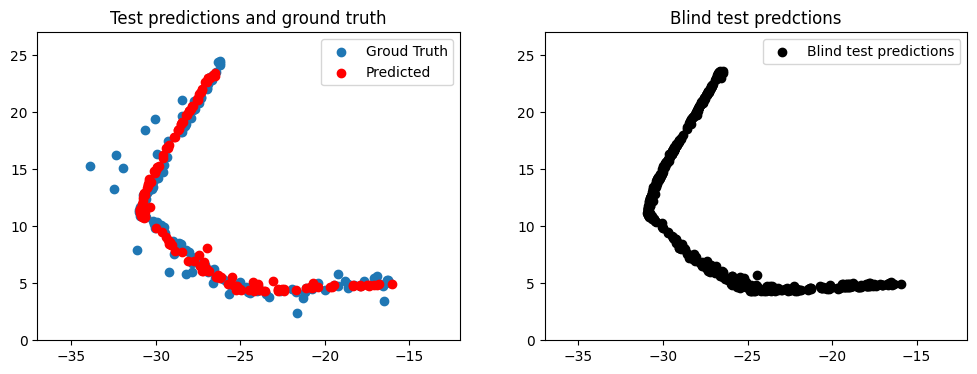

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))


#scatterplot of y_test and y_pred
ax1.scatter(y_test[:,1], y_test[:,0], label = 'Groud Truth')
ax1.scatter(y_pred[:,1], y_pred[:,0], color = 'red', label = 'Predicted')
ax1.legend()
ax1.set_ybound(0,27)
ax1.set_xbound(-37,-12)
ax1.set_title('Test predictions and ground truth')

y_cup = model.predict(X_blind_test)
ax2.scatter(y_cup[:,1], y_cup[:,0], c = 'k', label = 'Blind test predictions')
ax2.legend()
ax2.set_ybound(0,27)
ax2.set_xbound(-37,-12)
ax2.set_title('Blind test predctions')

## Learning curves of best model fitting on training set

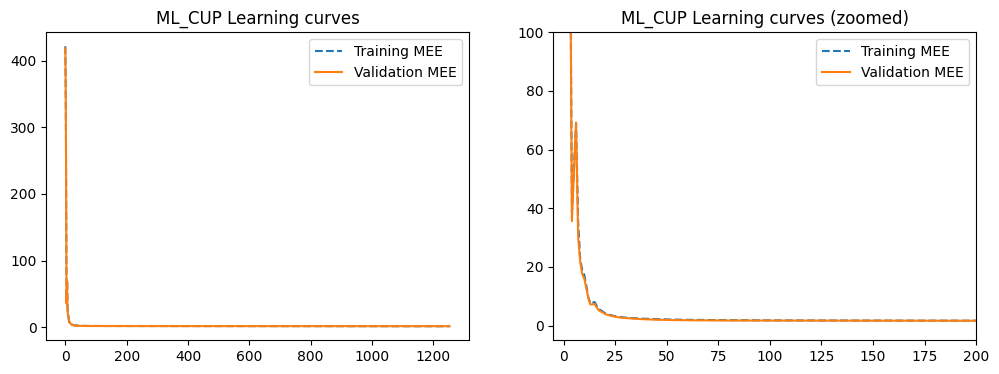

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,4))
ax1.plot(model.learning_curve, linestyle = '--', label = 'Training MEE')
ax1.plot(model.validation_curve, label = 'Validation MEE')
ax1.legend()
ax1.set_title('ML_CUP Learning curves')

ax2.plot(model.learning_curve, linestyle = '--', label = 'Training MEE')
ax2.plot(model.validation_curve, label = 'Validation MEE') 
ax2.legend()
ax2.set_title('ML_CUP Learning curves (zoomed)')

ax2.set_ybound(-5,100)
ax2.set_xbound(-5,200)

Save predictions for blind test in the correct format

In [44]:
from src.output import create_answers_file
create_answers_file(model.predict(X_blind_test))